# ERDOCTOR EDA

## Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Functions

## Load Dataset

First we load the dataset.

In [14]:
df = pd.read_excel('ERDOCTOR.xlsx')

Translate hebrew column names into english

In [16]:
df.rename(columns={'תאריך': 'Date'}, inplace=True)
df.rename(columns={'קוד רופא': 'Doctor_ID'}, inplace=True)
df.rename(columns={'כמות מטופלים': 'Patient_count'}, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65988 entries, 0 to 65987
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           65988 non-null  datetime64[ns]
 1   Doctor_ID      65988 non-null  int64         
 2   Patient_count  65988 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.5 MB


Check for null values.

In [19]:
np.sum(df.isnull(), axis = 0)

Date             0
Doctor_ID        0
Patient_count    0
dtype: int64

We can see that there are no null values, no data completion is required.

In [21]:
days_count = df['Doctor_ID'].value_counts()
days_count

Doctor_ID
9893     833
6777     830
11430    767
10923    762
6939     760
        ... 
8072       1
7886       1
12166      1
1618       1
1619       1
Name: count, Length: 1047, dtype: int64

We will find the number of patients for each doctor.

In [23]:
doctor_patient_totals = df.groupby('Doctor_ID')['Patient_count'].sum().reset_index()
doctor_patient_totals

,Doctor_ID,Patient_count
0,1003,35
1,1006,355
2,1007,143
3,1013,253
4,1014,104
...,...,...
1042,12931,235
1043,12932,711
1044,12933,201
1045,12937,68


We will now find the number of days each doctor has worked.

In [25]:
merged = pd.merge(days_count, doctor_patient_totals, on='Doctor_ID')
merged.rename(columns={'count': 'Days_Count'}, inplace=True)
merged

,Doctor_ID,Days_Count,Patient_count
0,9893,833,4103
1,6777,830,6451
2,11430,767,6702
3,10923,762,8713
4,6939,760,7053
...,...,...,...
1042,8072,1,1
1043,7886,1,1
1044,12166,1,1
1045,1618,1,1


We will find the average number of releases per day for each doctor.

In [27]:
merged['Patient_count'] = merged['Patient_count'].astype(float)
merged['average_releases_per_day'] = merged['Patient_count'] / merged['Days_Count']
merged

,Doctor_ID,Days_Count,Patient_count,average_releases_per_day
0,9893,833,4103.0,4.925570
1,6777,830,6451.0,7.772289
2,11430,767,6702.0,8.737940
3,10923,762,8713.0,11.434383
4,6939,760,7053.0,9.280263
...,...,...,...,...
1042,8072,1,1.0,1.000000
1043,7886,1,1.0,1.000000
1044,12166,1,1.0,1.000000
1045,1618,1,1.0,1.000000


In [28]:
# Round 'average_releases_per_day' to the nearest 0.1
merged['rounded_average_releases_per_day'] = (merged['average_releases_per_day'] * 10).round() / 10

In [29]:
# Count the occurrences of each rounded value
counts = merged['rounded_average_releases_per_day'].value_counts().sort_index()

We will calculate the mean and standard deviation of the average releases per day to find the doctors who were out of bounds in terms of releases.

In [31]:
mean_value = merged['rounded_average_releases_per_day'].mean()
std_dev = merged['rounded_average_releases_per_day'].std()

In [32]:
# Define the range for N standard deviations from the mean
N_std = 3
lower_bound = mean_value - N_std * std_dev
upper_bound = mean_value + N_std * std_dev

In [33]:
filtered_array = merged[(merged['rounded_average_releases_per_day'] <= lower_bound) |
                        (merged['rounded_average_releases_per_day'] >= upper_bound)]['rounded_average_releases_per_day'].values

In [34]:
print("\nAverage releases per day evaluation:\nSD = ", std_dev , " Mean = ", mean_value)
print("lower_bound = ", lower_bound, "\nupper_bound = ",upper_bound)
# Print the filtered array
print(f"\nDoctor Average releases per day -- outside {N_std} SDs (Doctor_ID: Average_Releases_Per_Day):")

# Filter the doctor codes where 'average_releases_per_day' is above the threshold
doctors_above_Nsd = merged[merged['average_releases_per_day'] > upper_bound]['Doctor_ID']
doctors_above_Nsd = [str(ele) for ele in doctors_above_Nsd]
releases_outside_of_SD_dict = dict(zip(doctors_above_Nsd, filtered_array))
print(releases_outside_of_SD_dict)


Average releases per day evaluation:
SD =  2.4173504608759613  Mean =  4.144699140401146
lower_bound =  -3.107352242226738 
upper_bound =  11.39675052302903

Doctor Average releases per day -- outside 3 SDs (Doctor_ID: Average_Releases_Per_Day):
{'10923': 11.4, '6773': 12.9, '10033': 12.1, '10760': 12.5, '10126': 13.1, '9095': 13.5, '7806': 13.0}


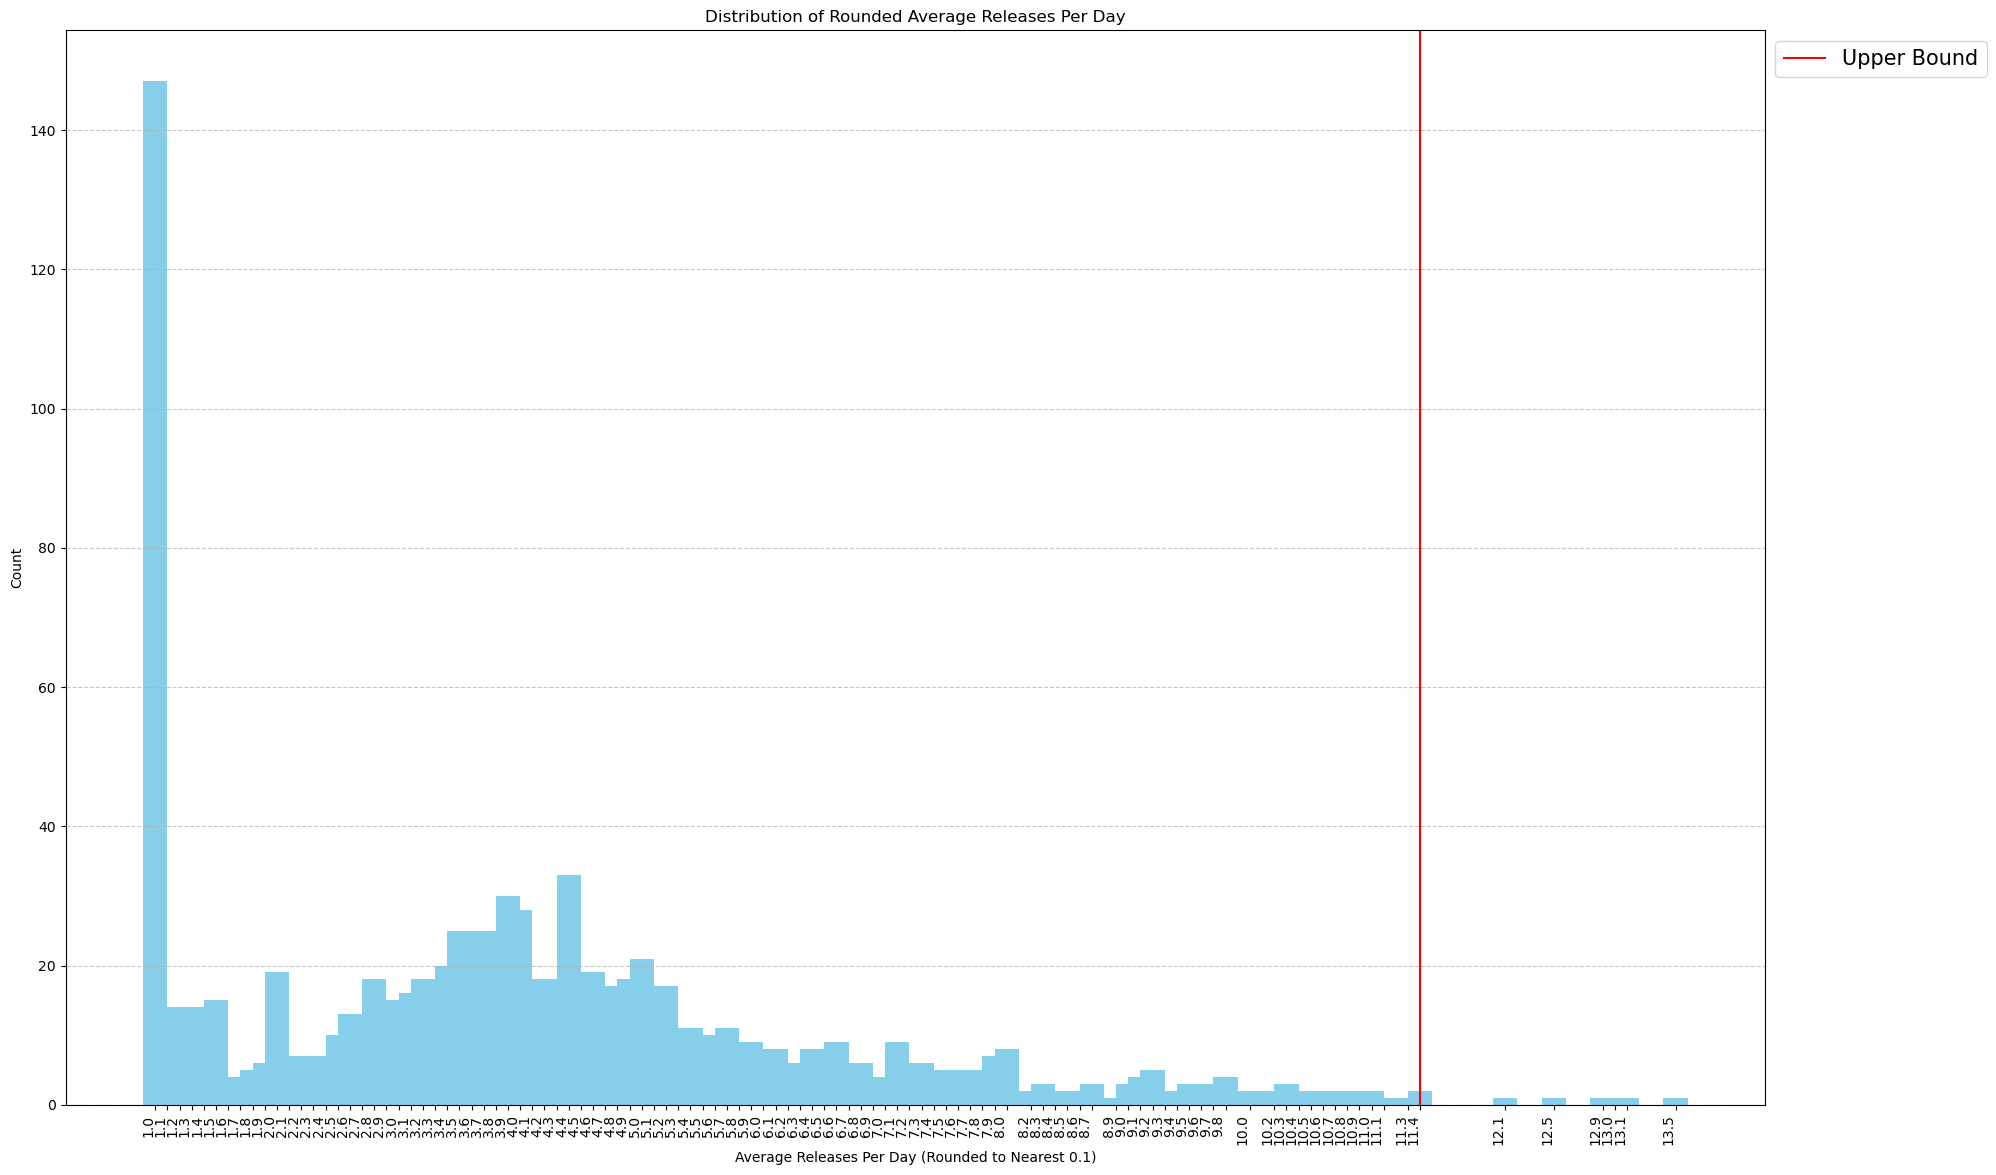

In [35]:
# Plot the histogram (bar chart)
plt.figure(figsize=(18, 12))
plt.bar(counts.index, counts.values, width=0.2, color='skyblue')
# only one line may be specified; full height
plt.axvline(x = upper_bound, color = 'r', label = 'Upper Bound')

# Set labels and title
plt.xlabel('Average Releases Per Day (Rounded to Nearest 0.1)')
plt.ylabel('Count')
plt.title('Distribution of Rounded Average Releases Per Day')

# Customize x-axis ticks
plt.xticks(counts.index, rotation=90, ha='right')

# Show grid for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.rcParams.update({'font.size': 15})

# Adjust layout for better spacing
plt.tight_layout()

plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

# Show the plot
plt.show()

We can see that not many doctors were above the upper bound, but there are still some doctors who released many patients on average each day, far more than most doctors. 

We can also see that most doctors released patients after one day of being hospitalized.